In [11]:
import igl
from meshplot import plot
import numpy as np
import pygeodesic.geodesic as geodesic
import networkx as nx
import drawSvg as draw

#----------functions from the previous lecture "general unfolding polyhedra" modified slightly to support polygonal mesh-----------

# adds edges based on the adjacency of faces in the mesh
# CHANGE FOR POLYGONAL MESH removed igl.triangle_triangle_adjacency and used is_adjacent function
def add_edges_from_mesh(graph, faces):
    for current_face_id, current_face in enumerate(faces):
        for face_id, face in enumerate(faces):
            if is_adjacent(current_face, face) and current_face_id != face_id:
                graph.add_edge(current_face_id,face_id)

# adds nodes to graph G for every face in mesh
def add_nodes_from_mesh(graph, faces): [graph.add_node(face_id) for face_id, face in enumerate(faces)]

# create networkx graph from given mesh
def graph_from_mesh(faces):
    graph = nx.Graph()
    add_nodes_from_mesh(graph, faces)
    add_edges_from_mesh(graph, faces)
    return graph

# returns a rotation matrix from a (unnormalized) axis and an angle
def get_rotation_matrix(axis, angle):
    from scipy.spatial.transform import Rotation
    return Rotation.from_rotvec(axis/np.linalg.norm(axis) * angle).as_matrix()

# returns a matrix that maps 3D space onto a 2D plane (the orientation of which is specified by 'face_normal').
def get_2d_projection(face_normal):
    xy_plane_normal = np.array([0,0,1])  #  aka 'the z-axis'
    rotation_axis = np.cross(face_normal, xy_plane_normal)
    angle = np.arccos(np.clip(np.dot(xy_plane_normal, face_normal), -1.0, 1.0))

    discard_z_matrix = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])

    rotation_matrix = get_rotation_matrix(rotation_axis, angle)
    return discard_z_matrix.dot(rotation_matrix)

# find commone edge of two adjacent faces
# CHANGE FOR POLYGONAL MESH removed the hardcoded loop iterator 3 to len(face_vertex_array_a) as face arrays can be of any size
def find_common_edge(faces, face_id_a, face_id_b):
    # make sure that the resulting vertex ids are clockwise wrt. source face
    face_vertex_array_a = faces[face_id_a]
    face_vertex_array_b = faces[face_id_b]
    for i in range(len(face_vertex_array_a)):
        if face_vertex_array_a[i] in face_vertex_array_b and face_vertex_array_a[(i+1) % len(face_vertex_array_a)] in face_vertex_array_b:
            return (face_vertex_array_a[i], face_vertex_array_a[(i+1) % len(face_vertex_array_a)])

    return None

# get angle between the normals of two faces
def dihedral_angle(face_normals, face_a_id, face_b_id):
    return np.arccos(np.clip(np.dot(face_normals[face_a_id], face_normals[face_b_id]), -1.0, 1.0))

# update from edge unfolding: added "spanning_tree" as an input instead of generating graph inside the function from the vertices and faces
# update from general unfolding: added "face_normals" as an argument to simplyfy the code
def unfold(vertices, faces, face_normals, spanning_tree):
    polygons = []  # resulting polygons, represented as lists of 2D coordinates

    source_face_id = 0
    parent_dict = nx.dfs_predecessors(spanning_tree, source=source_face_id)  # format { node_id: parent_id, ... }
    parent_dict[source_face_id] = None  # add the source face, as networkX is not doing this by default

    for face_id, parent_face_id in parent_dict.items():
        # retrieve the coordinates of current face
        face_coordinates = [vertices[vertex_id] for vertex_id in faces[face_id]]
        
        # iterate over all parents and apply unfolding rotations accordingly
        selected_face_id = face_id
        selected_parent_face_id = parent_face_id

        while selected_face_id != source_face_id:
            # get edge between selected face and parent as tuple of two vertex_ids
            hinge_edge = find_common_edge(faces, selected_parent_face_id, selected_face_id)
            # apply unfolding transformation:
            # - all face_coordinates are offset such that the hinge_edge aligns with the origin
            # - then, the rotation around the hinge_edge is performed, such that the selected face
            #   and the parent lay in the same plane
            # - finally, we reverse the offset, such that the face ends up in its original position 
            offset = vertices[hinge_edge[0]]
            rotation_angle = dihedral_angle(face_normals, selected_face_id, selected_parent_face_id)
            rotation_axis = vertices[hinge_edge[0]] - vertices[hinge_edge[1]]
            rotation_matrix = get_rotation_matrix(rotation_axis, rotation_angle)
            # CHANGE FOR POLYGONAL MESH removed the hardcoded loop iterator 3 to len(face_coordinates) as face arrays can be of any size
            for i in range(len(face_coordinates)):
                face_coordinates[i] = rotation_matrix.dot(face_coordinates[i] - offset) + offset

            # climbing up the tree
            selected_face_id = selected_parent_face_id
            selected_parent_face_id = parent_dict[selected_parent_face_id]

        # project 3D coordinates into the 2D plane that
        # CHANGE FOR POLYGONAL MESH removed the hardcoded loop iterator 3 to len(face_coordinates) as face arrays can be of any size
        for i in range(len(face_coordinates)):
            face_coordinates[i] = get_2d_projection(face_normals[source_face_id]).dot(face_coordinates[i])
            
        polygons.append(face_coordinates)

    return polygons

In [12]:
# find out if two normals point in the same direction
def is_normal_same (normal_A, normal_B):
    result = False
    cross_ABAC = np.cross(normal_A, normal_B)
    # if cross product is zero then normal point in same (or opposite direction)
    if np.linalg.norm(cross_ABAC) < EPSILON: # check if result is zero with EPSILON tolerance
        result = True
    return result

# find out if one face is adjacent to another based on shared vertices
def is_adjacent (current_face, face):
    is_adjacent = False
    common_vertices = np.intersect1d(current_face, face)
    # if two or more vertices are shared the face is adjacent
    if len(common_vertices) >=2:
        is_adjacent = True
    return is_adjacent

# find out the adjacency array given polygonal faces
def find_adjacency(polygonal_faces):
    polgonal_adjacency =[]
    for current_face_id, current_face in enumerate(polygonal_faces):
        adjacency =[]
        for face_id, face in enumerate(polygonal_faces):
            if is_adjacent(current_face, face) and current_face_id != face_id:
                adjacency.append(face_id)
        polgonal_adjacency.append(adjacency)
    return polgonal_adjacency

# check if a given face is adjacent, shares a normal and has not been visited before
# as a candidate for merging
def find_adjacent_unvisited_faces_with_same_normal (current_face, current_normal, visited_faces, faces, face_normals):
    adjacent_faces = []
    for face_id, face in enumerate(faces):
        if is_adjacent(current_face, face) and is_normal_same(current_normal,face_normals[face_id]) and visited_faces[face_id] == 0:
            adjacent_faces.append(face_id)
    return adjacent_faces

# create polyhedral mesh from triangulated mesh by combining adjacent triangular faces that have the same normal
# into polygonal faces
def build_polyhedral_mesh(faces, face_normals):
    # keep track of faces that have been visited and merged
    visited_faces = np.zeros(len(faces))
    polygonal_faces = []
    polygonal_face_normals = []
    # loop through all triangular faces of the mesh
    for face_id, face in enumerate(faces):
        # avoid faces that have been previously visited and merged
        if visited_faces[face_id] == 0:
            # get the normal of the current triangle face (from igl) and add it to the list of normals for polygonal faces
            normal = face_normals[face_id]
            polygonal_face_normals.append(list(normal))
            # set the current face as visited
            visited_faces[face_id] = 1
            # find the faces that meet the three criteria: adjacent, normals point in the same direction and not already visited
            adjacent_face_ids = find_adjacent_unvisited_faces_with_same_normal (face, normal, visited_faces, faces, face_normals)
            # edge case handling: some faces might not have any faces that meet this criteria e.g. face on side of triangular prism
            # in this case, add the dace itself to the polygonal face list
            if len(adjacent_face_ids) < 1:
                polygonal_faces.append(list(face))
            # regular case
            else:
                # repeat until all adjacent faces with same normals have been visited and merged
                while len(adjacent_face_ids) > 0:
                    # loop thorugh all faces that meet the criteria for a merge
                    for adjacent_face_id in adjacent_face_ids:
                        # ignore previously visited faces
                        if visited_faces[adjacent_face_id] != 1:
                            visited_faces[adjacent_face_id] = 1
                            # get the vertex array of the adjacent face
                            adjacent_face = faces[adjacent_face_id]
                            # merge the adjacent face and update the polygonal face
                            face = merge_triangles(face, adjacent_face)
                        
                    # find the faces that meet the three criteria for the polygonal face: adjacent, normals point in the same direction and not already visited
                    adjacent_face_ids = find_adjacent_unvisited_faces_with_same_normal (face, normal, visited_faces, faces, face_normals) 
                # add the completed polygonal face to the polygonal face list
                polygonal_faces.append(face)
    return polygonal_faces, polygonal_face_normals

# merge two faces together. "face" is the polygonal face that will be merged into, while "adjacent_face" is the face to be merged. both are arrays of vertices
def merge_triangles(face, adjacent_face):
    # convert to list for easier handling
    result_face = list(face)
    # we find the common vertices between face and adjacent face and their location
    common_vertices, common_vertices_index, _ = np.intersect1d(result_face, adjacent_face, return_indices=True)
    sorted_index = np.sort(common_vertices_index)
    # if there are only two common vertices = edge is shared
    if len(sorted_index) == 2:
        # figure out which vertex in the triangle is the one that needs to be added
        incoming_vertex = set(adjacent_face).difference(common_vertices).pop()
        # find location to insert the new vertex
        # if vertices are next to each other then insert the new vertex at the bigger index e.g. [1, 2, 0] and new vertex goes between 2 and 0 i.e. insert it at index 2
        if abs(sorted_index[0]-sorted_index[1]) == 1:
            insert_location = sorted_index[1]
        # if vertices are not next to each other i.e. at the edges of the array then insert the new vertex at the smaller index, which would be the bigger index in the circular array, e.g. [0, 1, 2] and new vertex goes between 2 and 0, so smaller number is bigger index i.e insert it at index 0.
        else:
            insert_location = sorted_index[0]
        # and insert it
        result_face.insert(insert_location, incoming_vertex)
        
    # edge case handling when all three vertices of the triangular face are already part of the polygonal face array
    # e.g. if the preceeding faces have encircled the face before encountering it
    # = two or three edges are shared
    else:
        # these three vertices will occur in sequence in the polygonal face array (difference sequence then triangular face array)
        # delete the vertex in the middle of this sequence to add the triangle i.e. deleting two edges and creating a new one
        # boxy_2 is the example .stl that has this problem

        # if both start and end index are there then the vertex to be deleted is the last one in the sort i.e. circular array
        # e.g. [10  4  2] are the vertices in the face array
        # [4, 5, 3, 0, 1, 8, 9, 10, 2] are the vertices of the polygonal array
        # [8 0 7] are the locations in the polygonal array, [0 7 8] are the sorted result, delete vertex at location 8
        if 0 in sorted_index and len(result_face)-1 in sorted_index:
            del result_face[sorted_index[2]]
        # otherwise the sequence is in the middle of the array and the index in the middle should be deleted  
        else:
            del result_face[sorted_index[1]]      
    return result_face

#-----------TODOs start here:---------------------

# TODO check for overlaps at each step of adding strip_faces to the unfolding_tree
    # use the "unfold" function on the "unfolding_tree" to generate the polygons and shapely "intersects" to find overlaps
    # if a strip face cannot be placed add it to the wing_faces for connection during the wing step
# TODO check for overlaps at each step of adding the wing_faces
    # iteratively check adjacency for wing faces to find a position that does not overlap
    # if the wing cannot be attached at all add it back to the wing_faces and check again after another wing face has been sucessfully placed
    # repeat until all wing faces that can be added without overlaps have been added to the unfolding_tree
# TODO return list of faces that were not added to the unfolding along with the unfolding_tree

# create the strip unfolding spanning tree
def strip_unfold(faces, normals, adjacency):
    # find suitable strip faces
    all_faces = list(range(len(faces)))

    wing_normals = [
        np.array([1, 0, 0]),
        np.array([0, 1, 0]),
        np.array([0, 0, 1]),
    ]
    
    # create a filter prefix for all wing normals
    filter_prefixs = [lambda f: not is_normal_same(normals[f], i) for i in
        wing_normals]

    # find best strip
    # strip faces are all_faces except with certain normal
    # create all possible strips by filtering all_faces to all filter prefixs
    pos_strips = [set(filter(prefix, all_faces)) for prefix in filter_prefixs]

    # use the best (= longest) strip in further code
    strip_faces = max(pos_strips, key=lambda a: len(a))

    # wing faces are all_faces which are not strip_faces
    wing_faces = set(all_faces).difference(strip_faces)

    # define an empty graph
    unfolding_tree = nx.Graph()
    # build a graph out of the strip_faces based on face adjacency
    for face in strip_faces:
        for adj_face in adjacency[face]:
            if adj_face in strip_faces:
                unfolding_tree.add_edge(face, adj_face)
    # minimum_spanning_tree will build the strip
    unfolding_tree = nx.minimum_spanning_tree(unfolding_tree)
    
    # add wing faces on first adjacency found
    
    for face in wing_faces:
        adj_faces = set(adjacency[face])
        # all possible positions where the wing_face could attach 
        pos_positions = list(adj_faces.intersection(strip_faces))
        # attach the wing to first found position
        unfolding_tree.add_edge(face, pos_positions[0])

    return unfolding_tree

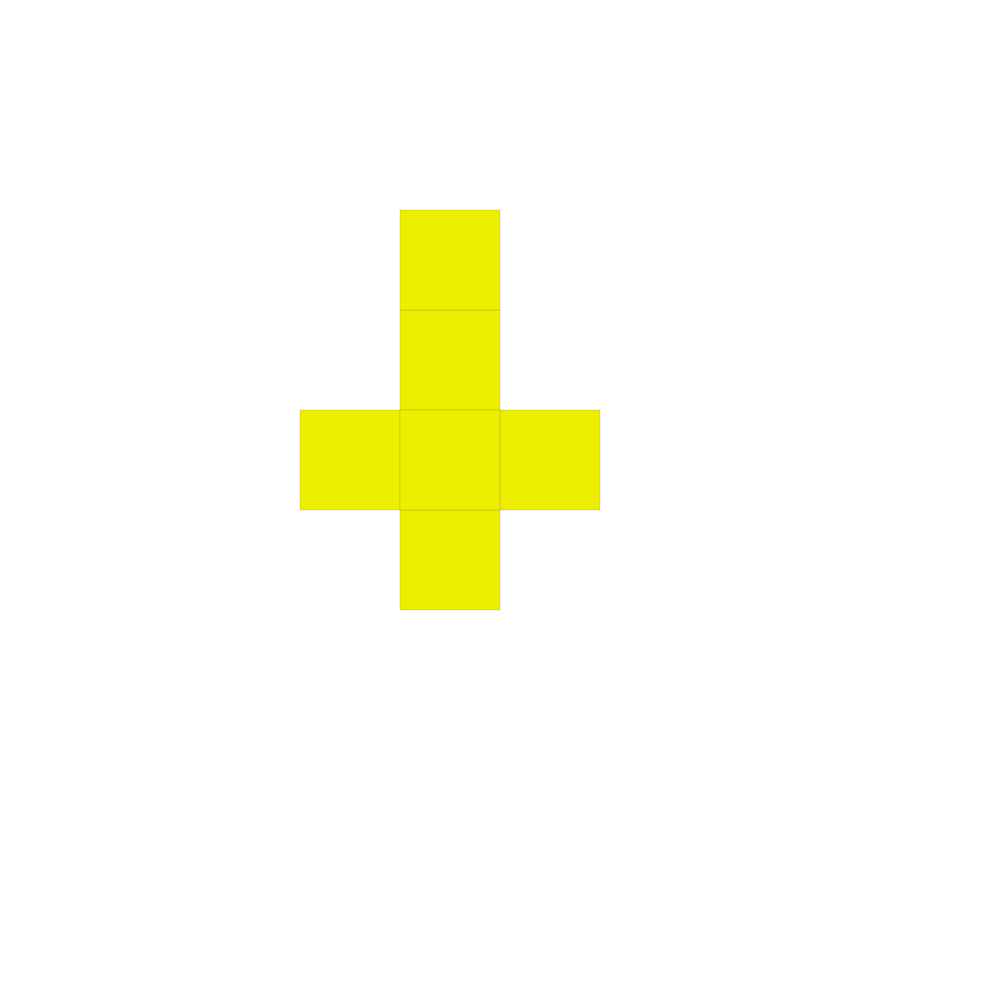

In [13]:
raw_vertices, raw_faces = igl.read_triangle_mesh("cube.stl")
vertices, faces, _ = igl.remove_duplicates(raw_vertices, raw_faces, 0.00001)
face_normals = igl.per_face_normals(vertices, faces, np.ones((1, 3)))

EPSILON = 1e-5

polygonal_faces, polygonal_face_normals= build_polyhedral_mesh(faces, face_normals)

# find the adjacency list array for the polygonal faces
polgonal_adjacency = find_adjacency(polygonal_faces)

# find the spanning tree for the strip unfolding
unfolding_tree = strip_unfold(polygonal_faces, polygonal_face_normals, polgonal_adjacency)

# unfold along the unfolding spanning tree
polygons = unfold(vertices, polygonal_faces, polygonal_face_normals, unfolding_tree)

# generate svg visualization
drawing = None
drawing = draw.Drawing(1000, 1000, origin='center')
for polygon in polygons:
    # polygon = [coords[0:2] for coords in polygon]
    drawing.append(draw.Lines(*np.array(polygon).flatten()*5,
                   close=True, fill='#eeee00', stroke='#000', stroke_width=.1))

drawing.rasterize()
drawing